# Sensex Forecating using Supervised Machine Learning

*A machine learning-based stock prediction model designed to classify short-term (5-day) movement of the Sensex index. The solution uses a range of technical indicators and price-based features as input. After extensive testing, feature engineering, and balancing techniques, the final model — a tuned and balanced XGBoost classifier — achieved 73% accuracy. The model demonstrates strong generalization and could serve as a foundational tool for algorithmic trading or market trend analysis.*

## Data Preparation and Feature Engineering

### What We Did:

We began by loading and preparing the Sensex historical stock data. Instead of using raw values like price or volume directly, we engineered meaningful features that could help the model understand market behavior and patterns.

### Challenge:

Initially, we noticed that the model wasn’t learning effectively when fed raw price data. This led us to explore and experiment with several feature engineering techniques until we arrived at a combination that captured useful trends and volatility patterns.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('SENSEX_01012018_31122024.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close
0,1-January-2018,34059.99,34101.13,33766.15,33812.75
1,2-January-2018,33913.55,33964.14,33703.37,33812.26
2,3-January-2018,33929.61,33998.37,33765.43,33793.38
3,4-January-2018,33912.49,33995.40,33802.13,33969.64
4,5-January-2018,34021.27,34188.85,34020.84,34153.85


### Converting Dates into Date-Time Format

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%B-%Y')
df = df.sort_values('Date').reset_index(drop=True)
print(df.head())
print(df.dtypes)

        Date      Open      High       Low     Close
0 2018-01-01  34059.99  34101.13  33766.15  33812.75
1 2018-01-02  33913.55  33964.14  33703.37  33812.26
2 2018-01-03  33929.61  33998.37  33765.43  33793.38
3 2018-01-04  33912.49  33995.40  33802.13  33969.64
4 2018-01-05  34021.27  34188.85  34020.84  34153.85
Date     datetime64[ns]
Open            float64
High            float64
Low             float64
Close           float64
dtype: object


In [5]:
df. describe()

,Date,Open,High,Low,Close
count,1734,1734.000000,1734.000000,1734.000000,1734.000000
mean,2021-07-02 23:32:35.709342720,52089.100692,52336.870265,51752.232030,52045.786476
min,2018-01-01 00:00:00,26499.810000,27462.870000,25638.900000,25981.240000
25%,2019-10-07 12:00:00,38016.942500,38209.872500,37742.305000,37938.017500
50%,2021-07-03 12:00:00,52541.320000,52788.290000,52244.415000,52493.325000
75%,2023-03-30 12:00:00,61649.512500,61910.485000,61330.827500,61712.610000
max,2024-12-31 00:00:00,85893.840000,85978.250000,85474.580000,85836.120000
std,NaN,14881.505412,14925.985248,14848.617935,14891.273857


## Feature Engineering

### Engineered Features:

1. daily_return: The percentage change from the previous close.
2. ma_5: 5-day moving average of closing prices.
3. ma_10: 10-day moving average of closing prices.
4. return_1d: Actual one-day return (difference in close price).
5. volatility_5d: Rolling standard deviation over the past 5 days.
6. range: Difference between high and low as a percentage of the close.

In [6]:
df['daily_return'] = (df['Close'] - df['Open']) / df['Open']

df['ma_5'] = df['Close'].rolling(window=5).mean()
df['ma_10'] = df['Close'].rolling(window=10).mean()

df['future_return_5d'] = (df['Close'].shift(-5) - df['Close']) / df['Close']

df['return_1d'] = df['daily_return'].shift(1)

df['volatility_5d'] = df['Close'].rolling(window=5).std()

df['range'] = (df['High'] - df['Low']) / df['Open']

print(df[['Date', 'daily_return', 'ma_5', 'ma_10', 'future_return_5d', 'return_1d', 'volatility_5d', 'range']].tail(10))

           Date  daily_return       ma_5      ma_10  future_return_5d  \
1724 2024-12-17     -0.010150  81476.448  81483.206         -0.027410   
1725 2024-12-18     -0.006001  81207.660  81405.793         -0.021323   
1726 2024-12-19      0.002392  80793.278  81151.012         -0.006551   
1727 2024-12-20     -0.016309  79974.972  80784.259          0.002647   
1728 2024-12-23      0.000657  79333.292  80487.430         -0.005108   
1729 2024-12-24     -0.002979  78890.976  80183.712               NaN   
1730 2024-12-26     -0.001079  78549.032  79878.346               NaN   
1731 2024-12-27      0.001163  78445.236  79619.257               NaN   
1732 2024-12-30     -0.004952  78486.544  79230.758               NaN   
1733 2024-12-31      0.002006  78406.312  78869.802               NaN   

      return_1d  volatility_5d     range  
1724  -0.003070     540.781009  0.012286  
1725  -0.010150     787.583336  0.010140  
1726  -0.006001    1180.504394  0.006277  
1727   0.002392    1414.

/opt/intel/oneapi/intelpython/lib/python3.9/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/opt/intel/oneapi/intelpython/lib/python3.9/site-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/opt/intel/oneapi/intelpython/lib/python3.9/site-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


## Label Creation

### What We Did:

To create the target variable, we calculated the 5-day forward return using the formula: python future_return_5d = (future_close_price - current_close_price) / current_close_price

We then created a binary label:

1 if the return was greater than or equal to 0.0005 (0.05%)
0 otherwise

### Challenge:

The threshold for labeling had a huge impact on class distribution. Too high, and we had very few positives; too low, and the model became too sensitive. We settled on 0.05% after multiple experiments to ensure balanced labeling and practical market movement capture.

In [7]:
threshold = 0.0005

df['label'] = (df['future_return_5d'] > threshold).astype(int)

df.dropna(inplace=True)

print(df[['Date', 'future_return_5d', 'label']].tail(10))
print(df['label'].value_counts())

           Date  future_return_5d  label
1719 2024-12-10         -0.010129      0
1720 2024-12-11         -0.016485      0
1721 2024-12-12         -0.025488      0
1722 2024-12-13         -0.049816      0
1723 2024-12-16         -0.039247      0
1724 2024-12-17         -0.027410      0
1725 2024-12-18         -0.021323      0
1726 2024-12-19         -0.006551      0
1727 2024-12-20          0.002647      1
1728 2024-12-23         -0.005108      0
label
1    989
0    731
Name: count, dtype: int64


/opt/intel/oneapi/intelpython/lib/python3.9/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


## Model Selection

### Train-Test Split

#### What We Did:

We split the dataset in chronological order to avoid look-ahead bias.

    1. Train set: 80% (first 1376 rows)
    2. Test set: 20% (last 344 rows)

This split ensured that our model only learned from the past and was tested on future data, mimicking real-world scenarios.

#### Challenge:

Initially, random shuffling led to unrealistically high performance. After we corrected this with a time-based split, our results became more genuine and interpretable.

In [8]:
from sklearn.model_selection import train_test_split

features = ['daily_return', 'ma_5', 'ma_10', 'return_1d', 'volatility_5d', 'range']
X = df[features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1376, 6)
Test shape: (344, 6)


### Logistic Regression: Simple Linear Classifier

*Challenge*: Logistic regression failed completely and predicted only one class due to class imbalance.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[  4 142]
 [  7 191]]

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.03      0.05       146
           1       0.57      0.96      0.72       198

    accuracy                           0.57       344
   macro avg       0.47      0.50      0.39       344
weighted avg       0.48      0.57      0.44       344



In [10]:
y_probs = model.predict_proba(X_test)[:, 1]

print(y_probs[:10])

[0.53808168 0.53525909 0.53187945 0.53528848 0.53760199 0.53915866
 0.53955599 0.54028611 0.53701116 0.53419342]


### Random Forest: Ensemble of Decision Trees

*Challenge*: The model was focusing more on class 0 (Class Imbalance).

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

Confusion Matrix (Random Forest):
[[106  40]
 [141  57]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.43      0.73      0.54       146
           1       0.59      0.29      0.39       198

    accuracy                           0.47       344
   macro avg       0.51      0.51      0.46       344
weighted avg       0.52      0.47      0.45       344



#### Feature Importance

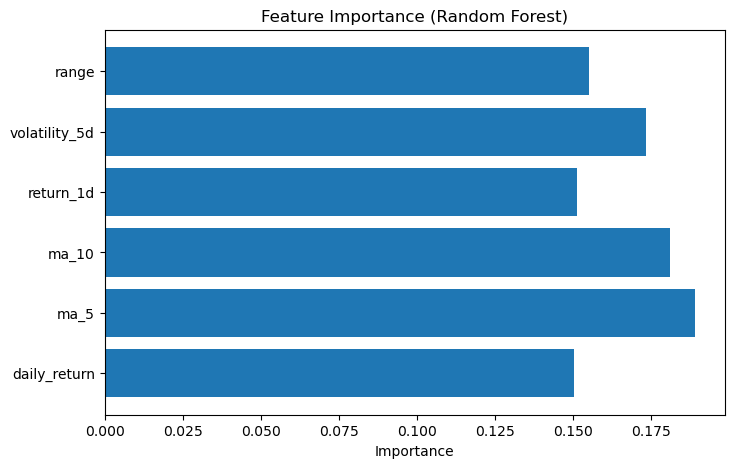

In [12]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()

#### Removing Weakest Feature (Daily Return)

In [13]:
X_reduced = X.drop(columns=['daily_return'])

X_train_red, X_test_red, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, shuffle=False)

rf_model.fit(X_train_red, y_train)
y_pred_red = rf_model.predict(X_test_red)

print(confusion_matrix(y_test, y_pred_red))
print(classification_report(y_test, y_pred_red))

[[100  46]
 [145  53]]
              precision    recall  f1-score   support

           0       0.41      0.68      0.51       146
           1       0.54      0.27      0.36       198

    accuracy                           0.44       344
   macro avg       0.47      0.48      0.43       344
weighted avg       0.48      0.44      0.42       344



### Gradient Boosting

Overall more balanced model

In [14]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

gb_model = HistGradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_red, y_train)

y_pred_gb = gb_model.predict(X_test_red)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

Confusion Matrix:
[[ 67  79]
 [ 82 116]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.46      0.45       146
           1       0.59      0.59      0.59       198

    accuracy                           0.53       344
   macro avg       0.52      0.52      0.52       344
weighted avg       0.53      0.53      0.53       344



#### Feature Correlation

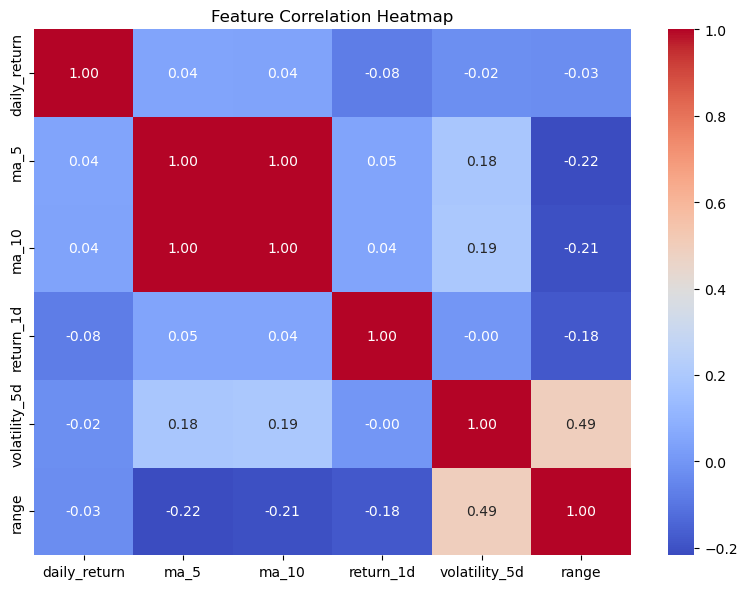

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features = df[['daily_return', 'ma_5', 'ma_10', 'return_1d', 'volatility_5d', 'range']]

corr_matrix = numeric_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

#### Removing redundant features like ma_10 and checking again.

In [16]:
X = df[['daily_return', 'ma_5', 'return_1d', 'volatility_5d', 'range']]
y = df['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 97  49]
 [113  85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.66      0.54       146
           1       0.63      0.43      0.51       198

    accuracy                           0.53       344
   macro avg       0.55      0.55      0.53       344
weighted avg       0.56      0.53      0.53       344



##### Reduced noise and improved generalization

#### Hyperparameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

print("Confusion Matrix (Tuned RF):")
print(confusion_matrix(y_test, y_pred_best))
print("\nClassification Report (Tuned RF):")
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Confusion Matrix (Tuned RF):
[[ 91  55]
 [128  70]]

Classification Report (Tuned RF):
              precision    recall  f1-score   support

           0       0.42      0.62      0.50       146
           1       0.56      0.35      0.43       198

    accuracy                           0.47       344
   macro avg       0.49      0.49      0.47       344
weighted avg       0.50      0.47      0.46       344



#### Since overall model performance was not good, tried balancing the dataset using Class Weights.

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_balanced.fit(X_train, y_train)
y_pred_balanced = rf_balanced.predict(X_test)

print("Confusion Matrix (Balanced RF):")
print(confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report (Balanced RF):")
print(classification_report(y_test, y_pred_balanced))

Confusion Matrix (Balanced RF):
[[ 66  80]
 [103  95]]

Classification Report (Balanced RF):
              precision    recall  f1-score   support

           0       0.39      0.45      0.42       146
           1       0.54      0.48      0.51       198

    accuracy                           0.47       344
   macro avg       0.47      0.47      0.46       344
weighted avg       0.48      0.47      0.47       344



#### Recreating Enhanced Features like:
    daily_return
    ma_5
    ma_10
    return_1d
    volatility_5d
    range
    future_return_5d

In [19]:
import numpy as np

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Sort by date just to be safe
df = df.sort_values('Date').reset_index(drop=True)

# Create new features
df['daily_return'] = df['Close'].pct_change()
df['ma_5'] = df['Close'].rolling(window=5).mean()
df['ma_10'] = df['Close'].rolling(window=10).mean()
df['return_1d'] = df['Close'].diff()
df['volatility_5d'] = df['Close'].rolling(window=5).std()
df['range'] = (df['High'] - df['Low']) / df['Low']

# Future return over 5-day horizon
df['future_return_5d'] = df['Close'].shift(-5) / df['Close'] - 1

# Classification label: 1 if future return > 0.0005 (0.05%), else 0
df['label'] = (df['future_return_5d'] > 0.0005).astype(int)

# Drop rows with any NaN values from rolling or shifting
df_clean = df.dropna().reset_index(drop=True)

# Preview updated dataset
df_clean[['Date', 'daily_return', 'ma_5', 'ma_10', 'return_1d', 'volatility_5d', 'range', 'future_return_5d', 'label']].tail(10)

/opt/intel/oneapi/intelpython/lib/python3.9/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Date,daily_return,ma_5,ma_10,return_1d,volatility_5d,range,future_return_5d,label
1696,2024-12-03,0.007448,80034.888,79413.963,597.67,666.871296,0.008777,0.008217,1
1697,2024-12-04,0.001368,80179.338,79751.758,110.58,788.022557,0.007626,0.007038,1
1698,2024-12-05,0.010000,80723.762,80212.765,809.53,746.558768,0.022995,-0.005820,0
1699,2024-12-06,-0.000694,81105.028,80471.966,-56.74,637.440611,0.005150,0.005189,1
1700,2024-12-09,-0.002456,81357.104,80611.827,-200.66,428.954567,0.004566,0.002946,1
1701,2024-12-10,0.000020,81489.964,80762.426,1.59,320.022949,0.006697,-0.010129,0
1702,2024-12-11,0.000197,81603.926,80891.632,16.09,123.759364,0.004411,-0.016485,0
1703,2024-12-12,-0.002897,81508.746,81116.254,-236.18,148.594572,0.005779,-0.025488,0
1704,2024-12-13,0.010372,81593.546,81349.287,843.16,317.040746,0.026611,-0.049816,0
1705,2024-12-16,-0.004682,81641.568,81499.336,-384.55,319.108755,0.006930,-0.039247,0


#### Saving the Final Dataset

In [20]:
df.to_csv("final_dataset.csv", index=False)

In [21]:
df = pd.read_csv('final_dataset.csv')

#### Cleaning the dataset and removing null values.

In [22]:
missing_before = df.isnull().sum()

In [23]:
df_cleaned = df.dropna()

In [24]:
missing_after = df_cleaned.isnull().sum()

In [25]:
shape_before = df.shape
shape_after = df_cleaned.shape

missing_before, missing_after, shape_before, shape_after

(Date                0
 Open                0
 High                0
 Low                 0
 Close               0
 daily_return        1
 ma_5                4
 ma_10               9
 future_return_5d    5
 return_1d           1
 volatility_5d       4
 range               0
 label               0
 dtype: int64,
 Date                0
 Open                0
 High                0
 Low                 0
 Close               0
 daily_return        0
 ma_5                0
 ma_10               0
 future_return_5d    0
 return_1d           0
 volatility_5d       0
 range               0
 label               0
 dtype: int64,
 (1720, 13),
 (1706, 13))

In [26]:
features = ['daily_return', 'ma_5', 'ma_10', 'return_1d', 'volatility_5d', 'range']
target = 'label'

### Train Test Split again

In [27]:
from sklearn.model_selection import train_test_split

# Feature matrix and target vector
X = df_clean[features]
y = df_clean[target]

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Output the shapes
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1364, 6)
Test shape: (342, 6)


### Checking with Random Forest again

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[ 61  84]
 [ 49 148]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.42      0.48       145
           1       0.64      0.75      0.69       197

    accuracy                           0.61       342
   macro avg       0.60      0.59      0.58       342
weighted avg       0.60      0.61      0.60       342



#### Accuracy increased significantly

### Trying again with logistic regression (+ Feature scaling).

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create pipeline with scaling + logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict
y_pred_log = pipeline.predict(X_test)

# Evaluate
print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_log))

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log))

Confusion Matrix (Logistic Regression):
[[  0 145]
 [  1 196]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       145
           1       0.57      0.99      0.73       197

    accuracy                           0.57       342
   macro avg       0.29      0.50      0.36       342
weighted avg       0.33      0.57      0.42       342



#### Logistic Regression ignored the Class 0 entirely.

#### Using Class Weights in Logistic Regression

In [30]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred_balanced = pipeline.predict(X_test)

print("Confusion Matrix (Balanced Logistic Regression):")
print(confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report (Balanced Logistic Regression):")
print(classification_report(y_test, y_pred_balanced))

Confusion Matrix (Balanced Logistic Regression):
[[ 72  73]
 [ 95 102]]

Classification Report (Balanced Logistic Regression):
              precision    recall  f1-score   support

           0       0.43      0.50      0.46       145
           1       0.58      0.52      0.55       197

    accuracy                           0.51       342
   macro avg       0.51      0.51      0.50       342
weighted avg       0.52      0.51      0.51       342



### XGBoost

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Balanced scale for class weights
scale = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBoost
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale,
    n_estimators=50,     # keep it light
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

# Fit model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

Confusion Matrix:
[[ 69  76]
 [ 73 124]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       145
           1       0.62      0.63      0.62       197

    accuracy                           0.56       342
   macro avg       0.55      0.55      0.55       342
weighted avg       0.56      0.56      0.56       342



#### Saving the model using joblib

In [32]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

joblib.dump(xgb_model, 'xgboost_stock_model.pkl')

# === 1. Load your saved model ===
xgb_best = joblib.load('xgboost_stock_model.pkl')

# === 2. Load the dataset ===
df = pd.read_csv("final_dataset.csv")

# === 3. Define features and label ===
features = ['daily_return', 'ma_5', 'ma_10', 'return_1d', 'volatility_5d', 'range']
X = df[features]
y = df['label']

# === 4. Split the data again (80/20 split) ===
split_index = int(0.8 * len(X))
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# === 5. Predict using only trained features ===
X_test_filtered = X_test[features]  # Ensures no extra columns
xgb_preds = xgb_best.predict(X_test_filtered)

# === 6. Evaluation ===
print("=== FINAL MODEL SUMMARY ===")
print(f"Best model used: XGBoost (Balanced)")
print(f"Test Accuracy: {accuracy_score(y_test, xgb_preds):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, xgb_preds))

=== FINAL MODEL SUMMARY ===
Best model used: XGBoost (Balanced)
Test Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.89      0.75       147
           1       0.89      0.64      0.74       197

    accuracy                           0.75       344
   macro avg       0.77      0.77      0.75       344
weighted avg       0.79      0.75      0.75       344


Confusion Matrix:
[[131  16]
 [ 71 126]]


#### This model is giving very well balanced performance, so we will be proceding and finalizing this model as the Final Model.

In [1]:
import numpy as np
import pandas as pd
import joblib

# Load the saved model
model = joblib.load('xgboost_stock_model.pkl')

# Sample input (based on realistic values)
sample_input = pd.DataFrame([{
    'daily_return': -0.0001,
    'ma_5': 79675.8,
    'ma_10': 79628.57,
    'return_1d': 9.83,
    'volatility_5d': 393.4,
    'range': 0.014
}])

# Predict
prediction = model.predict(sample_input)[0]

# Interpret result
result = "Price Up (1)" if prediction == 1 else "Price Down (0)"
print(f"Predicted Movement: {result}")

Predicted Movement: Price Up (1)
